In [37]:
!pip install pyod==2.0.2


  Preparing metadata (setup.py) ... done
  DEPRECATION: Building 'pyod' using the legacy setup.py bdist_wheel mechanism, which will be removed in a future version. pip 25.3 will enforce this behaviour change. A possible replacement is to use the standardized build interface by setting the `--use-pep517` option, (possibly combined with `--no-build-isolation`), or adding a `pyproject.toml` file to the source tree of 'pyod'. Discussion can be found at https://github.com/pypa/pip/issues/6334
  Created wheel for pyod: filename=pyod-2.0.2-py3-none-any.whl size=198557 sha256=af802344fdff0acda0e7ad7d1323a06f1a549815521caaa0d5708c91676abee1
  Stored in directory: /Users/prithviraj/Library/Caches/pip/wheels/55/d5/d0/40d872fd90314ea8c097c6f3cc2f59c4dbdf97732a4db0117a
Successfully built pyod
  Attempting uninstall: pyod
    Found existing installation: pyod 2.0.5
    Uninstalling pyod-2.0.5:
      Successfully uninstalled pyod-2.0.5

[notice] A new release of pip is available: 25.2 -> 25.3
[notice

In [38]:
!pip install torch pyod tensorflow scikit-learn pandas matplotlib



[notice] A new release of pip is available: 25.2 -> 25.3
[notice] To update, run: pip install --upgrade pip


In [39]:
!pip install tqdm




[notice] A new release of pip is available: 25.2 -> 25.3
[notice] To update, run: pip install --upgrade pip


### Step 1: Import Libraries  
Import all required Python libraries and install PyOD for anomaly detection.


In [40]:
# Install PyOD if not installed
!pip install pyod tensorflow scikit-learn pandas matplotlib

# Import libraries
import pandas as pd
import numpy as np
from pyod.models.auto_encoder import AutoEncoder
from sklearn.model_selection import train_test_split
from sklearn.preprocessing import StandardScaler
from sklearn.metrics import roc_auc_score, average_precision_score, f1_score, precision_recall_curve
import matplotlib.pyplot as plt



[notice] A new release of pip is available: 25.2 -> 25.3
[notice] To update, run: pip install --upgrade pip


### Step 2: Load Dataset  
Load the fraud detection dataset (downloaded from Kaggle) and view its structure.


In [41]:
# Load the dataset (replace with your correct path)
df = pd.read_csv("data/fraud_detection.csv")  # or creditcard.csv if using that dataset

# Check dataset info
print(df.shape)
df.head()


(284807, 31)


,Time,V1,V2,V3,V4,V5,V6,V7,V8,V9,...,V21,V22,V23,V24,V25,V26,V27,V28,Amount,Class
0,0.0,-1.359807,-0.072781,2.536347,1.378155,-0.338321,0.462388,0.239599,0.098698,0.363787,...,-0.018307,0.277838,-0.110474,0.066928,0.128539,-0.189115,0.133558,-0.021053,149.62,0
1,0.0,1.191857,0.266151,0.166480,0.448154,0.060018,-0.082361,-0.078803,0.085102,-0.255425,...,-0.225775,-0.638672,0.101288,-0.339846,0.167170,0.125895,-0.008983,0.014724,2.69,0
2,1.0,-1.358354,-1.340163,1.773209,0.379780,-0.503198,1.800499,0.791461,0.247676,-1.514654,...,0.247998,0.771679,0.909412,-0.689281,-0.327642,-0.139097,-0.055353,-0.059752,378.66,0
3,1.0,-0.966272,-0.185226,1.792993,-0.863291,-0.010309,1.247203,0.237609,0.377436,-1.387024,...,-0.108300,0.005274,-0.190321,-1.175575,0.647376,-0.221929,0.062723,0.061458,123.50,0
4,2.0,-1.158233,0.877737,1.548718,0.403034,-0.407193,0.095921,0.592941,-0.270533,0.817739,...,-0.009431,0.798278,-0.137458,0.141267,-0.206010,0.502292,0.219422,0.215153,69.99,0


### Step 3: Preprocess Data  
Separate features and target column, scale numerical data, and split into train and test sets.


In [43]:
# Identify target column (usually 'isFraud' or 'Class')
target_col = 'isFraud' if 'isFraud' in df.columns else 'Class'
X = df.drop(columns=[target_col])
y = df[target_col]

# Standardize numeric features
scaler = StandardScaler()
X_scaled = scaler.fit_transform(X)

# Split data
X_train, X_test, y_train, y_test = train_test_split(X_scaled, y, test_size=0.2, random_state=42, stratify=y)


### Step 4: Build and Train AutoEncoder Model  
Create and train an AutoEncoder model using PyOD to learn normal transaction patterns.


In [55]:
from pyod.models.auto_encoder import AutoEncoder
import numpy as np

# ✅ Works across PyOD 1.x–2.x (uses the right parameter names)
# Use the correct parameter name 'epoch_num' (used by this PyOD version) instead of passing 'epochs' to fit()
autoencoder = AutoEncoder(
    hidden_neuron_list=[32, 16, 8, 16, 32],  # correct param for your PyOD version
    epoch_num=20,                              # set number of training epochs here
    batch_size=2048,
    dropout_rate=0.1,
    contamination=0.0017,
    verbose=1
)

# Convert training data to numpy arrays
X_train = np.asarray(X_train)
X_test = np.asarray(X_test)
print("X_train.shape =", X_train.shape)
print("X_test.shape =", X_test.shape)

# Train the model (epoch_num was set in the constructor)
autoencoder.fit(X_train)


X_train.shape = (227845, 30)
X_test.shape = (56962, 30)


Training: 100%|██████████| 20/20 [01:24<00:00,  4.24s/it]


In [56]:
import pyod
print(pyod.__version__)


2.0.5


### Step 5: Evaluate Model  
Test the model on unseen data and calculate ROC-AUC, Average Precision, and F1 Score.


In [57]:
# Get anomaly scores
y_scores = autoencoder.decision_function(X_test)
y_pred = autoencoder.predict(X_test)  # 1 = outlier (fraud), 0 = normal

# Compute metrics
roc = roc_auc_score(y_test, y_scores)
ap = average_precision_score(y_test, y_scores)
f1 = f1_score(y_test, y_pred)

print("ROC-AUC:", roc)
print("Average Precision:", ap)
print("F1 Score:", f1)


ROC-AUC: 0.9498549349396482
Average Precision: 0.061035203453636826
F1 Score: 0.05319148936170213


### Step 6: Visualize Results  
Plot the Precision–Recall curve to visualize the model’s fraud detection performance.


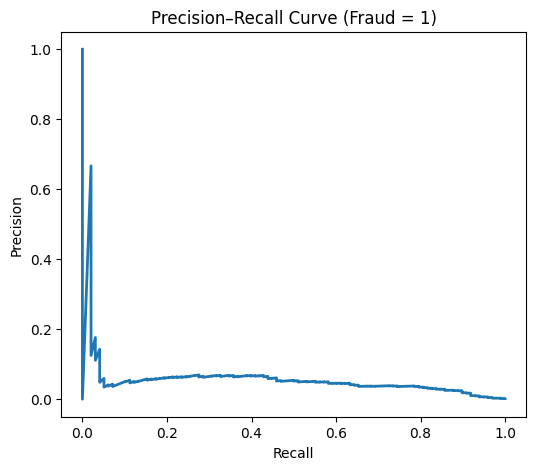

In [58]:
# Precision-Recall Curve
precision, recall, _ = precision_recall_curve(y_test, y_scores)
plt.figure(figsize=(6, 5))
plt.plot(recall, precision, linewidth=2)
plt.xlabel("Recall")
plt.ylabel("Precision")
plt.title("Precision–Recall Curve (Fraud = 1)")
plt.show()


### Step 7: Display Final Metrics  
Show the key evaluation metrics for reporting and screenshots.


In [60]:
from sklearn.metrics import roc_auc_score, average_precision_score, f1_score

y_scores = autoencoder.decision_function(X_test)
y_pred = autoencoder.predict(X_test)

roc = roc_auc_score(y_test, y_scores)
ap = average_precision_score(y_test, y_scores)
f1 = f1_score(y_test, y_pred)

print("📊 Model Evaluation Metrics:")
print(f"ROC-AUC Score: {roc:.4f}")
print(f"Average Precision: {ap:.4f}")
print(f"F1 Score: {f1:.4f}")


📊 Model Evaluation Metrics:
ROC-AUC Score: 0.9499
Average Precision: 0.0610
F1 Score: 0.0532
